### 1. Importing modules

In [1]:
import pandas as pd
import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np

### 2. Reading data

In [2]:
current_folder = os.getcwd()
data_path = f"{current_folder}"
data_file_names = os.listdir(data_path)

In [3]:
data = pd.read_csv(f'{data_path}/202301-citibike-tripdata_sample.csv')


print('Dimension of data is', data.shape)
data.head(2)

Dimension of data is (79999, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,DC1CB984821DFFF7,classic_bike,3:36:53 PM,3:39:45 PM,Vesey St & Church St,5216.06,Albany St & Greenwich St,5145.02,40.712220,-74.010472,40.709267,-74.013247,member
1,C00CA02971557F16,classic_bike,7:23:01 PM,7:34:57 PM,Lispenard St & Broadway,5391.06,St Marks Pl & 1 Ave,5626.13,40.719392,-74.002472,40.727791,-73.985649,member


### 3. Cleaning data

In [4]:
data.isna().sum()

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name      650
end_station_id        650
start_lat               0
start_lng               0
end_lat               206
end_lng               206
member_casual           0
dtype: int64

In [5]:
# Removing rides that are a loop
data = data[(data.start_station_id != data.end_station_id)&(data.start_station_name != data.end_station_name)]

# Removing rides with no end station or no start stations
data = data[data.end_station_name.notna()]


In [6]:
# Cleaning dtypes
data = data.astype({'ride_id': 'string', 
             'rideable_type': 'category', 
            #  'start_station_name': 'category', 
             'start_station_id': 'category', 
            #  'end_station_name': 'category',
             'end_station_id': 'category', 
             'start_lat': 'float',
             'start_lng': 'float',
             'end_lat': 'float',
             'end_lng': 'float',
             'member_casual': 'category'})

data.started_at = pd.to_datetime(data.started_at, format="%I:%M:%S %p")
data.ended_at = pd.to_datetime(data.ended_at, format="%I:%M:%S %p")

data.dtypes

ride_id               string[python]
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id            category
end_station_name              object
end_station_id              category
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual               category
dtype: object

### 4. Picking 300 stations at random
The 300 stations will act as either starting or ending stations to build our network

In [7]:
random.seed(70)

start_stations = data[['start_station_name','start_lat','start_lng']]
start_stations.columns=['station','lat','lng']
end_stations = data[['end_station_name','end_lat','end_lng']]
end_stations.columns=['station','lat','lng']
stations = pd.concat([start_stations, end_stations]).drop_duplicates()
random_numbers = random.sample(range(1, len(stations),1), 50)
stations = stations.iloc[random_numbers].reset_index(drop=True).reset_index(names='station_id')
stations.loc[:,'station_id'] = stations.loc[:,'station_id'] + 1
stations

,station_id,station,lat,lng
0,1,E 47 St & 1 Ave,40.752160,-73.967896
1,2,W 20 St & 8 Ave,40.743742,-74.000709
2,3,6 Ave & 9 St,40.668127,-73.983809
3,4,Broadway & W 58 St,40.766262,-73.981836
4,5,Stanton St & Norfolk St,40.720785,-73.986423
5,6,6 Ave & 9 St,40.668198,-73.983693
6,7,Steinway St & Ditmars Blvd,40.772717,-73.906127
7,8,E 2 St & Avenue C,40.720920,-73.980989
8,9,8 Ave & W 38 St,40.754408,-73.991658
9,10,W 51 St & Rockefeller Plaza,40.759442,-73.978386


In [8]:
# Taking a subset of bike trips that either begin or end at one of the 300 stations
data = data[(data.start_station_name.isin(stations.station)) & (data.end_station_name.isin(stations.station))]
data = data.reset_index(drop=True)
data.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C9EEE10CF2C7703D,electric_bike,1900-01-01 22:34:26,1900-01-01 22:42:24,Norfolk St & Broome St,5374.01,S 4 St & Rodney St,5156.05,40.717220,-73.987870,40.70934,-73.95608,casual
1,4AE80FFE4CC62E5E,electric_bike,1900-01-01 20:58:46,1900-01-01 21:08:39,Norfolk St & Broome St,5374.01,S 4 St & Rodney St,5156.05,40.717227,-73.988021,40.70934,-73.95608,member
2,8156A42AB7B99270,electric_bike,1900-01-01 17:25:40,1900-01-01 17:40:35,Norfolk St & Broome St,5374.01,S 4 St & Rodney St,5156.05,40.717188,-73.988011,40.70934,-73.95608,member
3,8762A7AAAB725224,electric_bike,1900-01-01 09:59:18,1900-01-01 10:11:42,Stanton St & Norfolk St,5445.07,S 4 St & Rodney St,5156.05,40.720747,-73.986274,40.70934,-73.95608,member
4,FC668B5F4976325D,classic_bike,1900-01-01 23:15:05,1900-01-01 23:33:02,Norfolk St & Broome St,5374.01,S 4 St & Rodney St,5156.05,40.717227,-73.988021,40.70934,-73.95608,member


In [9]:
# Understanding the demand of entire biking routes and assigning stations with their ids
route_demand = data.value_counts(['start_station_name','end_station_name'])
route_demand = route_demand.reset_index()
route_demand.loc[:, 'start_stn_id'] = route_demand.start_station_name.map(dict(zip(stations.station,stations.station_id)))
route_demand.loc[:, 'end_stn_id'] = route_demand.end_station_name.map(dict(zip(stations.station,stations.station_id)))
route_demand

,start_station_name,end_station_name,count,start_stn_id,end_stn_id
0,E 53 St & Lexington Ave,E 39 St & Lexington Ave,41,31,39
1,Bleecker St & Crosby St,E 2 St & Avenue C,31,30,44
2,Court St & State St,Columbia Heights & Cranberry St,22,11,26
3,Cooper Square & Astor Pl,E 2 St & Avenue C,21,45,44
4,W 59 St & 10 Ave,E 53 St & Lexington Ave,20,32,31
...,...,...,...,...,...
61,E 2 St & Avenue C,S 4 St & Rodney St,1,44,40
62,Court St & State St,E 2 St & Avenue C,1,11,44
63,Cooper Square & Astor Pl,E 53 St & Lexington Ave,1,45,31
64,Bleecker St & Crosby St,E 53 St & Lexington Ave,1,30,31


In [10]:
# Creating a graph object
G = nx.DiGraph()  # Using a directed graphs to mimic two-way traffic flow in the real world

for row in range(len(route_demand)):
    G.add_edge(route_demand.iloc[row,-2], route_demand.iloc[row,-1], weight=route_demand.iloc[row,2])

In [11]:
# Breaking the route into segments, keeping max of 2 segments per route for simplicity

route_demand.loc[:,'first_segment'] = None
route_demand.loc[:,'second_segment'] = None
for rno in range(len(route_demand)):
    try:
        all_paths = nx.all_simple_paths(G, source=route_demand.iloc[rno,:].start_stn_id, target=route_demand.iloc[rno,:].end_stn_id, cutoff=2)
        path = list(itertools.islice(map(nx.utils.pairwise, all_paths), 1, 2))
        path = [segment for segment in path[0]]
        route_demand.at[rno,'first_segment'] = path[0]
        route_demand.at[rno,'second_segment'] = path[1]

    except:
        route_demand.at[rno,'first_segment'] = tuple([route_demand.iloc[rno,:].start_stn_id, route_demand.iloc[rno,:].end_stn_id])


print(route_demand.second_segment.isnull().mean())
print(route_demand.first_segment.isnull().mean())
route_demand.head(2)

0.7121212121212122
0.0


,start_station_name,end_station_name,count,start_stn_id,end_stn_id,first_segment,second_segment
0,E 53 St & Lexington Ave,E 39 St & Lexington Ave,41,31,39,"(31, 10)","(10, 39)"
1,Bleecker St & Crosby St,E 2 St & Avenue C,31,30,44,"(30, 44)",None


In [12]:
# Assignming ids to segments
segments = pd.concat([route_demand['first_segment'], route_demand['second_segment']]).to_frame(name = 'segment').drop_duplicates().dropna().reset_index().reset_index(names = 'segment_id')
segments.loc[:,'segment_id'] = segments.loc[:,'segment_id'] + 1
segments

,segment_id,index,segment
0,1,0,"(31, 10)"
1,2,1,"(30, 44)"
2,3,2,"(11, 26)"
3,4,3,"(45, 44)"
4,5,4,"(32, 10)"
5,6,5,"(28, 44)"
6,7,6,"(4, 10)"
7,8,7,"(5, 44)"
8,9,8,"(1, 44)"
9,10,9,"(21, 10)"


In [13]:
route_demand.loc[:, 'first_segment_id'] = route_demand.first_segment.map(dict(zip(segments.segment, segments.segment_id)))
route_demand.loc[:, 'second_segment_id'] = route_demand.second_segment.map(dict(zip(segments.segment, segments.segment_id)))
route_demand

,start_station_name,end_station_name,count,start_stn_id,end_stn_id,first_segment,second_segment,first_segment_id,second_segment_id
0,E 53 St & Lexington Ave,E 39 St & Lexington Ave,41,31,39,"(31, 10)","(10, 39)",1,49.0
1,Bleecker St & Crosby St,E 2 St & Avenue C,31,30,44,"(30, 44)",None,2,NaN
2,Court St & State St,Columbia Heights & Cranberry St,22,11,26,"(11, 26)",None,3,NaN
3,Cooper Square & Astor Pl,E 2 St & Avenue C,21,45,44,"(45, 44)",None,4,NaN
4,W 59 St & 10 Ave,E 53 St & Lexington Ave,20,32,31,"(32, 10)","(10, 31)",5,20.0
...,...,...,...,...,...,...,...,...,...
61,E 2 St & Avenue C,S 4 St & Rodney St,1,44,40,"(44, 40)",None,44,NaN
62,Court St & State St,E 2 St & Avenue C,1,11,44,"(11, 44)",None,45,NaN
63,Cooper Square & Astor Pl,E 53 St & Lexington Ave,1,45,31,"(45, 31)",None,46,NaN
64,Bleecker St & Crosby St,E 53 St & Lexington Ave,1,30,31,"(30, 31)",None,47,NaN


In [14]:
segment_demand = pd.melt(
    route_demand[['first_segment_id', 'second_segment_id','count']],
    id_vars=['count'],
    value_vars=['first_segment_id', 'second_segment_id'],
    var_name='segment_type',
    value_name='segment_id'
)
segment_demand = pd.DataFrame(segment_demand[['segment_id','count']])
segment_demand.loc[:, 'segment'] = segment_demand.segment_id.map(segments.set_index('segment_id')['segment'].to_dict())
segment_demand = segment_demand.groupby(by=['segment_id', 'segment']).sum().reset_index()
segment_demand.columns = ['segment_id','segment','segment_demand']
segment_demand.loc[:,'start'] = segment_demand['segment'].apply(lambda x: x[0])
segment_demand.loc[:,'end'] = segment_demand['segment'].apply(lambda x: x[1])
segment_demand

,segment_id,segment,segment_demand,start,end
0,1.0,"(31, 10)",58,31,10
1,2.0,"(30, 44)",31,30,44
2,3.0,"(11, 26)",22,11,26
3,4.0,"(45, 44)",21,45,44
4,5.0,"(32, 10)",24,32,10
5,6.0,"(28, 44)",15,28,44
6,7.0,"(4, 10)",18,4,10
7,8.0,"(5, 44)",14,5,44
8,9.0,"(1, 44)",15,1,44
9,10.0,"(21, 10)",19,21,10


In [15]:
intersection_stn_demand_dummy = route_demand[['first_segment', 'first_segment_id', 'second_segment_id','count']].dropna().copy()
intersection_stn_demand_dummy.loc[:, 'intersection_stn'] = intersection_stn_demand_dummy['first_segment'].apply(lambda x: x[1])
intersection_stn_demand_dummy

,first_segment,first_segment_id,second_segment_id,count,intersection_stn
0,"(31, 10)",1,49.0,41,10
4,"(32, 10)",5,20.0,20,10
6,"(4, 10)",7,20.0,15,10
8,"(1, 44)",9,33.0,14,44
9,"(21, 10)",10,20.0,12,10
10,"(20, 31)",11,50.0,10,31
11,"(20, 10)",12,20.0,10,10
12,"(29, 44)",13,44.0,10,44
17,"(2, 31)",18,1.0,6,31
21,"(10, 31)",20,50.0,5,31


In [16]:
intersection_stn_demand = intersection_stn_demand_dummy[['intersection_stn','count']]
intersection_stn_demand = intersection_stn_demand.groupby(by=['intersection_stn']).sum().reset_index()
intersection_stn_demand.columns = ['intersection_stn','intersection_demand']

intersection_stn_demand.loc[:, 'adj_routes_thru_intrsctn'] = None

for intersection_stn in intersection_stn_demand[['intersection_stn']].itertuples(index=False):
    adj_routes_thru_intrsctn = []

    for row in intersection_stn_demand_dummy[intersection_stn_demand_dummy.intersection_stn == intersection_stn][['first_segment_id','second_segment_id']].itertuples(index=False):
        adj_routes_thru_intrsctn = adj_routes_thru_intrsctn + [(row.first_segment_id, row.second_segment_id)]
    
    index = intersection_stn_demand[intersection_stn_demand.intersection_stn == intersection_stn].index[0]
    intersection_stn_demand.at[index,'adj_routes_thru_intrsctn'] = adj_routes_thru_intrsctn

intersection_stn_demand

,intersection_stn,intersection_demand,adj_routes_thru_intrsctn
0,10,108,"[(1, 49.0), (5, 20.0), (7, 20.0), (10, 20.0), ..."
1,31,28,"[(11, 50.0), (18, 1.0), (20, 50.0), (22, 1.0),..."
2,44,33,"[(9, 33.0), (13, 44.0), (13, 33.0), (13, 34.0)]"


In [17]:
# pip install gurobipy

In [18]:
# Defining the optimization objective function variables
import gurobipy as gp

options = {
    "WLSACCESSID": "8d06512c-8f6f-4849-8f52-b8aa32fc5e40",
    "WLSSECRET": "45120f9d-c0ae-4abe-8b25-b6ab113a7dfe",
    "LICENSEID": 2593580,
}
env = gp.Env(params=options)

# Data
road_segments = segment_demand.segment_id.to_list()
segment_demand_dict = {k:v for k,v in segment_demand[['segment_id', 'segment_demand']].itertuples(index=False)}

adjacent_segments = []
for row in intersection_stn_demand['adj_routes_thru_intrsctn']:
        adjacent_segments = adjacent_segments + row

intersection_stn_demand_dict = {
    adjacent_segment: intersection_demand
    for adjacent_segments, intersection_demand in intersection_stn_demand.loc[:,['adj_routes_thru_intrsctn', 'intersection_demand']].itertuples(index=False)
    for adjacent_segment in adjacent_segments

}

# for segment in road_segments:
#     if not any(t[0] == segment for t in adjacent_segments):
#         intersection_stn_demand_dict[(segment, 1)] = 0

segment_cost = {k:30 for k in segment_demand['segment_id']}

B = 30*50 # Budget
lambda_param = 2  # Weight for continuity utility

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2593580
Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu


In [19]:
# Create the model
model = gp.Model(env=env, name="Bike Lane Planning")

# Decision variables
x = model.addVars(road_segments, vtype=gp.GRB.BINARY, name="x")  # Whether to build a bike lane on segment i
y = model.addVars(adjacent_segments, vtype=gp.GRB.BINARY, name="y")  # Adjacency utility

# Objective function: maximize utility
model.setObjective(
    sum(segment_demand_dict[i] * x[i] for i in road_segments) + lambda_param * sum(intersection_stn_demand_dict[i, j] * y[i, j] for i, j in adjacent_segments),
    gp.GRB.MAXIMIZE
)

# Constraints
# Budget constraint
model.addConstr(sum(segment_cost[i] * x[i] for i in road_segments) <= B, "Budget")

# Linearization constraints for y_ij
for i, j in adjacent_segments:
    print(i,j)
    model.addConstr(y[i, j] >= x[i] + x[j] - 1, f"Linear1_{i}_{j}")
    model.addConstr(y[i, j] <= x[i], f"Linear2_{i}_{j}")
    model.addConstr(y[i, j] <= x[j], f"Linear3_{i}_{j}")

# Solve the model
model.optimize()

# Display results
if model.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")
    print("Bike lanes on segments:")
    for i in road_segments:
        if x[i].x > 0.5:
            print(f"  Segment {i}, {x[i].x}")
    print("\nConnectivity utility:")
    for i, j in adjacent_segments:
        if y[i, j].x > 0.01:
            print(f"  Intersection ({i}, {j}): {y[i, j].x:.2f}")
    print(f"\nTotal utility: {model.objVal:.2f}")
else:
    print("No optimal solution found.")

1 49.0
5 20.0
7 20.0
10 20.0
12 20.0
23 20.0
30 49.0
35 20.0
10 49.0
11 50.0
18 1.0
20 50.0
22 1.0
18 50.0
22 50.0
9 33.0
13 44.0
13 33.0
13 34.0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))



CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0xec68c4c8
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 3105.0000000

Explored 0 nodes (0 simplex iterations) in 0.36 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 3105 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.105000000000e+03, best bound 3.105000000000e+03, gap 0.0000%
Optimal solution found!
Bike lanes on segments:
  Segment 1.0, 1.0
  Segm

In [20]:
# Create a graph object
def graph_network(nodes, edges, title):
    G = nx.DiGraph()  # Use `DiGraph` for directed graphs; otherwise use `Graph`

    for node, data in nodes.items():
        G.add_node(node, **data)
    for source, target, weight in edges:
        G.add_edge(source, target, weight=weight)

    pos = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

    plt.figure(figsize=(10, 7))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=300,
        node_color='blue',
        font_size=10,
        edge_color='gray',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

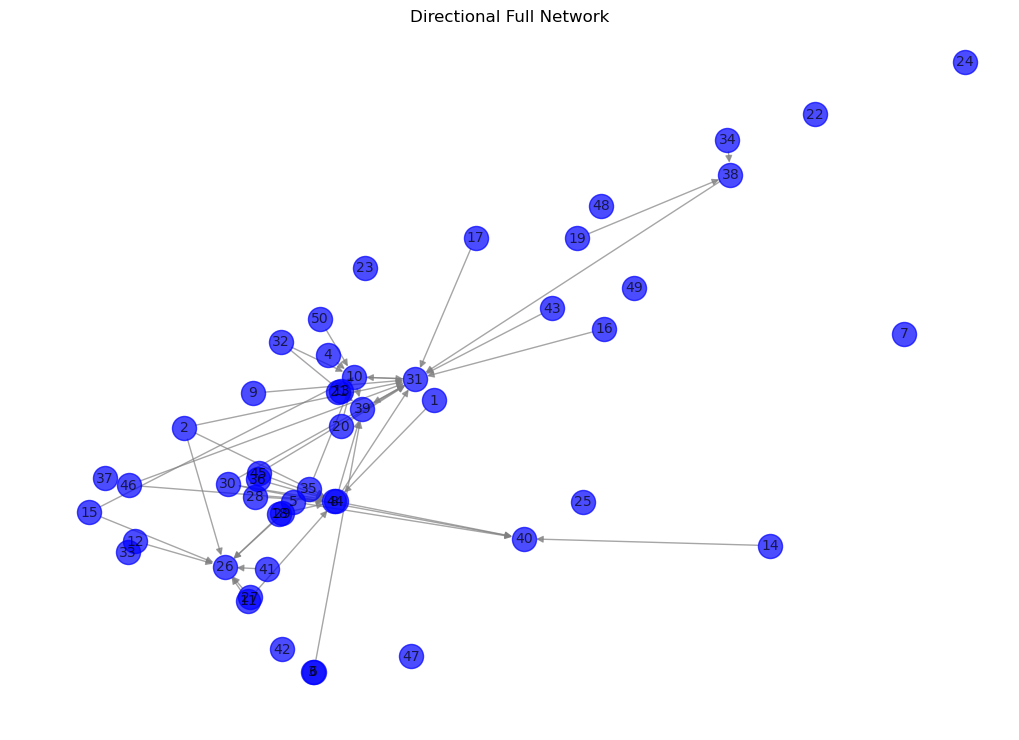

In [21]:
# Full network trajectory
nodes = {
        station_id: {'latitude': lat, 'longitude': lng} 
        for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
    }

edges = [(segment[0],segment[1], demand) for segment, demand in segment_demand[['segment','segment_demand']].itertuples(index=False)]
graph_network(nodes, edges, 'Directional Full Network')

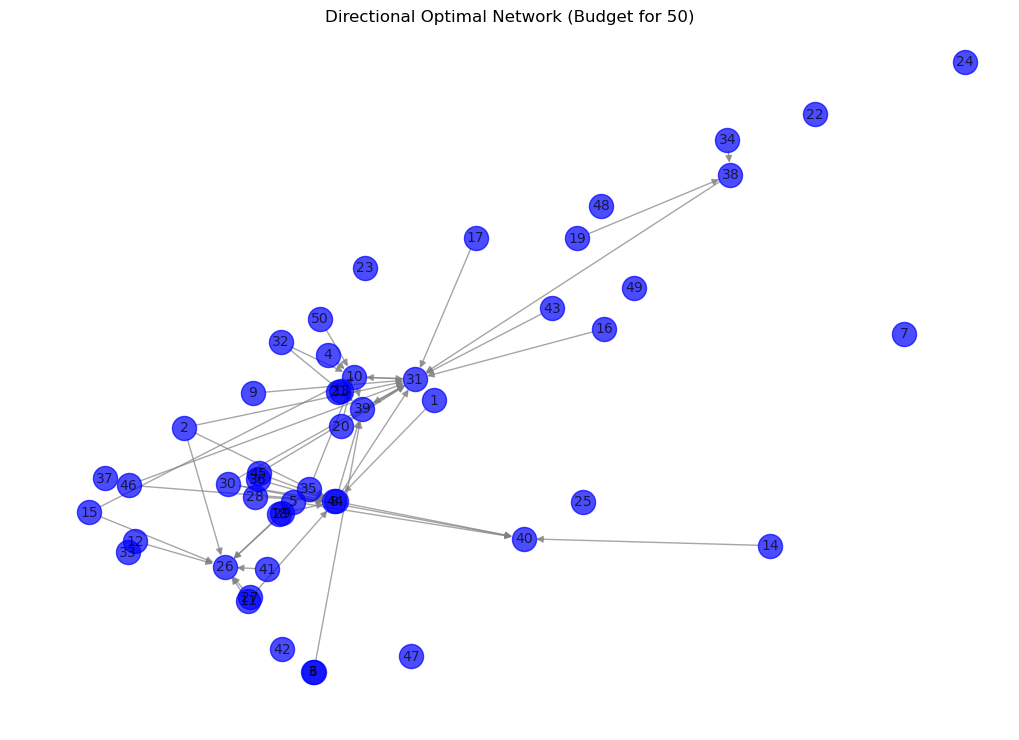

In [22]:
# Optimal network trajectory
nodes = {
        station_id: {'latitude': lat, 'longitude': lng} 
        for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
    }

edges = []
for i in road_segments:
        if x[i].x == 1:
            edges.extend((start,end,segment_demand) for start,end,segment_demand in segment_demand.loc[segment_demand.segment_id == i, ['start','end','segment_demand']].itertuples(index=False))

graph_network(nodes, edges, 'Directional Optimal Network (Budget for 50)')

### 5. Sensitivity analysis

In [23]:
def optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand, B, # Fixed environment variables
                       segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                       lambda_param, env,
                       title # title for graph network
                       ):
    
    # Create the model
    model = gp.Model(env=env, name="Bike Lane Planning")

    # Decision variables
    x = model.addVars(road_segments, vtype=gp.GRB.BINARY, name="x")  # Whether to build a bike lane on segment i
    y = model.addVars(adjacent_segments, vtype=gp.GRB.BINARY, name="y")  # Adjacency utility

    # Objective function: maximize utility
    model.setObjective(
        sum(segment_demand_dict[i] * x[i] for i in road_segments) + 
        lambda_param * sum(intersection_stn_demand_dict[i, j] * y[i, j] for i, j in adjacent_segments),
        gp.GRB.MAXIMIZE
    )

    # Constraints
    # Budget constraint
    model.addConstr(sum(segment_cost[i] * x[i] for i in road_segments) <= B, "Budget")

    # Linearization constraints for y_ij
    for i, j in adjacent_segments:
        model.addConstr(y[i, j] >= x[i] + x[j] - 1, f"Linear1_{i}_{j}")
        model.addConstr(y[i, j] <= x[i], f"Linear2_{i}_{j}")
        model.addConstr(y[i, j] <= x[j], f"Linear3_{i}_{j}")

    # Solve the model
    model.optimize()
    
    # Collect results
    if model.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        print("Bike lanes on segments:")
        for i in road_segments:
            if x[i].x > 0.5:
                print(f"  Segment {i}, {x[i].x}")
        print("\nConnectivity utility:")
        for i, j in adjacent_segments:
            if y[i, j].x > 0.01:
                print(f"  Intersection ({i}, {j}): {y[i, j].x:.2f}")
        print(f"\nTotal utility: {model.objVal:.2f}")

        # Optimal network trajectory
        
        nodes = {
            station_id: {'latitude': lat, 'longitude': lng} 
            for station_id, lat, lng in stations[['station_id', 'lat', 'lng']].itertuples(index=False)
        }

        edges = []
        for i in road_segments:
                if x[i].x == 1:
                    edges.extend((start,end,segment_demand) for start,end,segment_demand in segment_demand.loc[segment_demand.segment_id == i, ['start','end','segment_demand']].itertuples(index=False))

        graph_network(nodes, edges, title)

    else:
        print("No optimal solution found.")    
    

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0x042c5052
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 561.0000000

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 561 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.610000000000e+02, best bound 5.610000000000e+02, gap 0

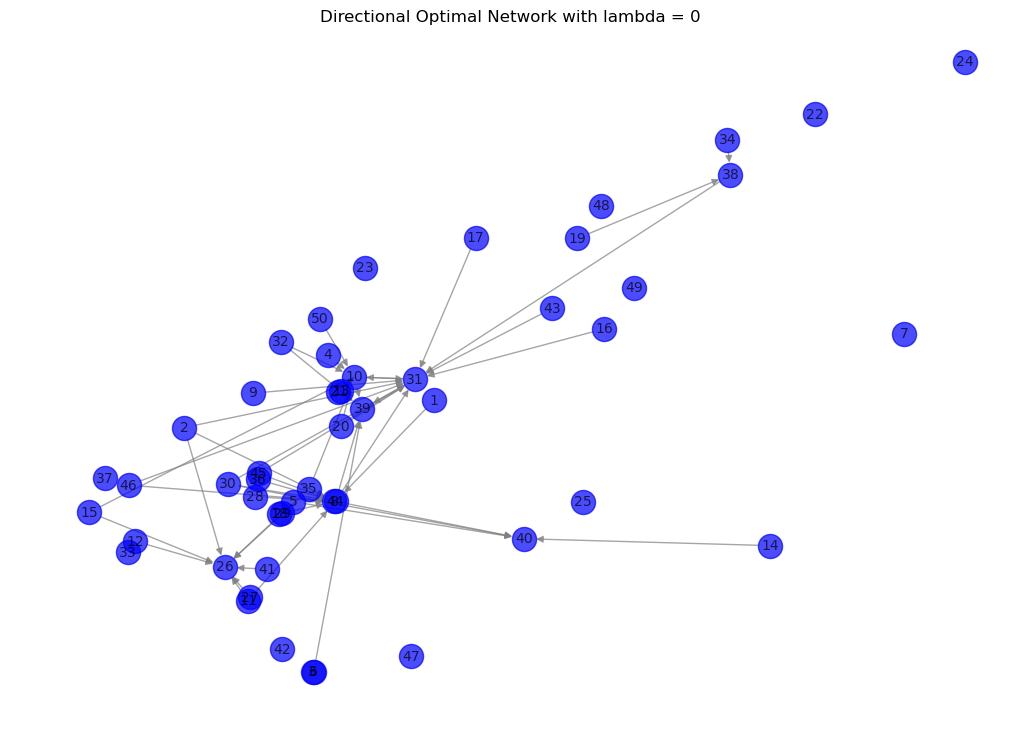

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0xf668b449
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [3e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 573.7200000

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 573.72 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.737200000000e+02, best bound 5.737200000000e+02, ga

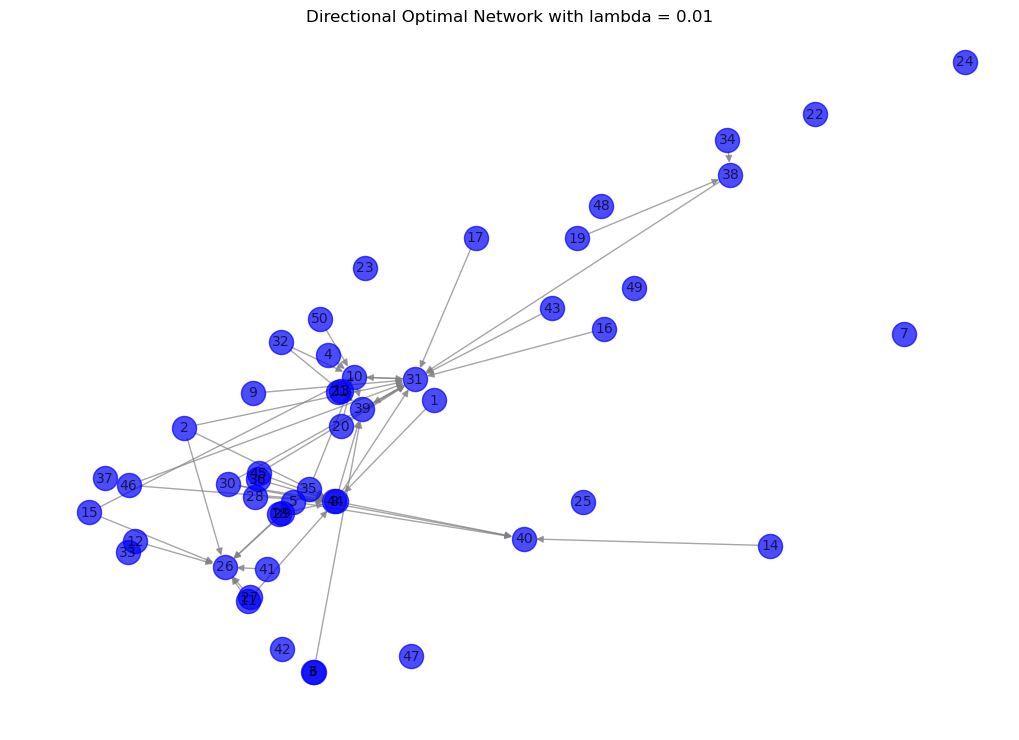

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0xc33ccc24
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 650.0400000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 650.04 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.500400000000e+02, best bound 6.500400000000e+02, ga

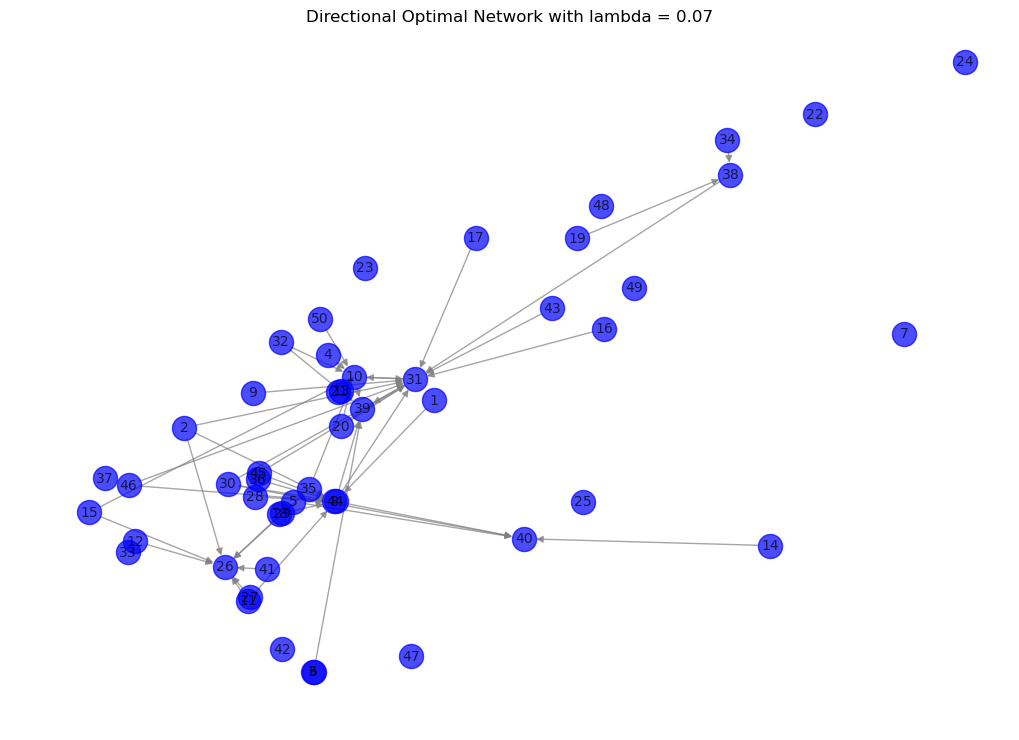

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0x354a9505
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 688.2000000

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 688.2 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.882000000000e+02, best bound 6.882000000000e+02, gap

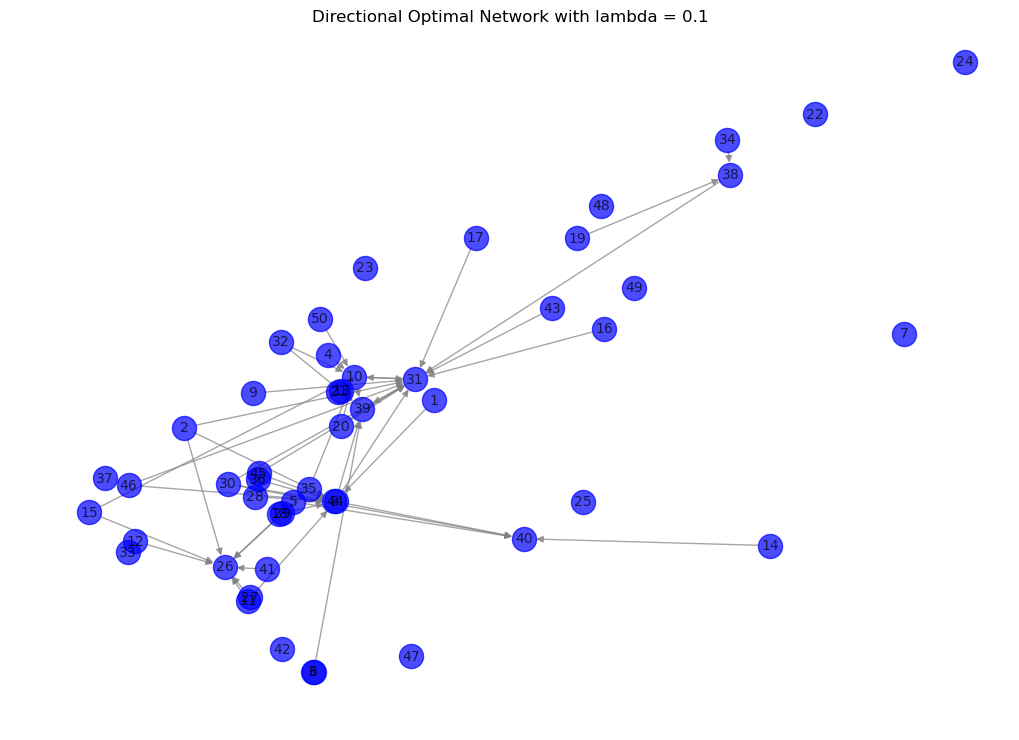

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0x6c626db7
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 1833.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 1833 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.833000000000e+03, best bound 1.833000000000e+03, gap

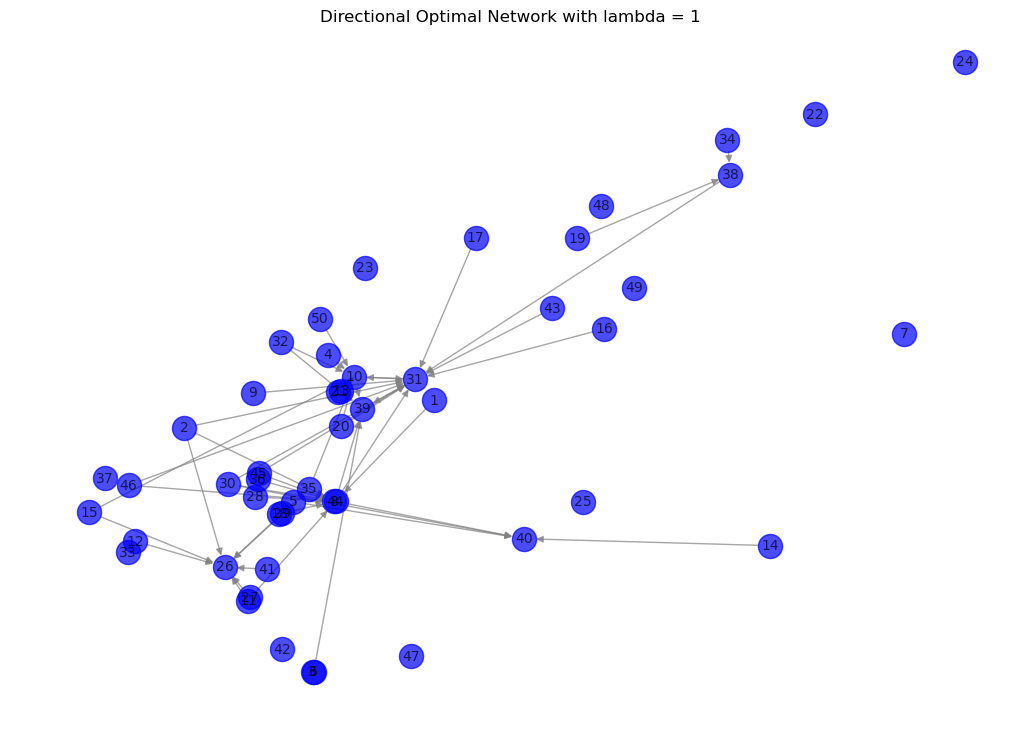

In [24]:
lambda_values = [0, 0.01, 0.07, 0.1, 1]  # Lambda values from 0 to 0.1
for lambda_param in lambda_values:
    optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand,B, # Fixed environment variables
                       segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                       lambda_param, env,
                       f'Directional Optimal Network with lambda = {lambda_param}'
                       )

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0x6c626db7
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 372.0000000
Found heuristic solution: objective 1833.0000000

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 1833 372 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.833000000000e+03, best bound 1.833000000000e+03, gap

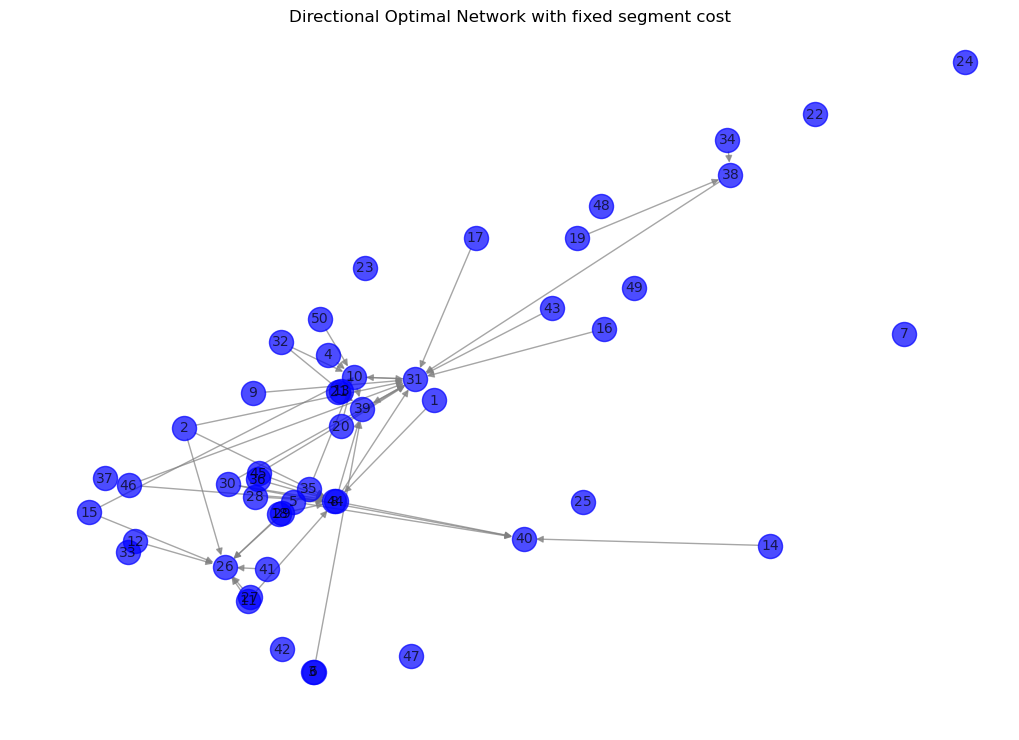

In [25]:
fixed_segment_cost = [30 for i in range(len(segment_demand['segment_id']))]
segment_cost = {k:c for k,c in zip(segment_demand['segment_id'], fixed_segment_cost)}

optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict, stations, segment_demand, B, # Fixed environment variables
                    segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                    lambda_param, env,
                    f'Directional Optimal Network with fixed segment cost'
                    )

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads



Academic license 2593580 - for non-commercial use only - registered to ri___@andrew.cmu.edu
Optimize a model with 58 rows, 69 columns and 183 nonzeros
Model fingerprint: 0x82883e90
Variable types: 0 continuous, 69 integer (69 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 357.0000000
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 39 rows, 68 columns, 125 nonzeros
Variable types: 0 continuous, 68 integer (67 binary)
Found heuristic solution: objective 401.0000000

Root relaxation: objective 1.803727e+03, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1803.72727    0    1  401.00000 1803.72727   350%     -    0s
H    0     0                    1789.

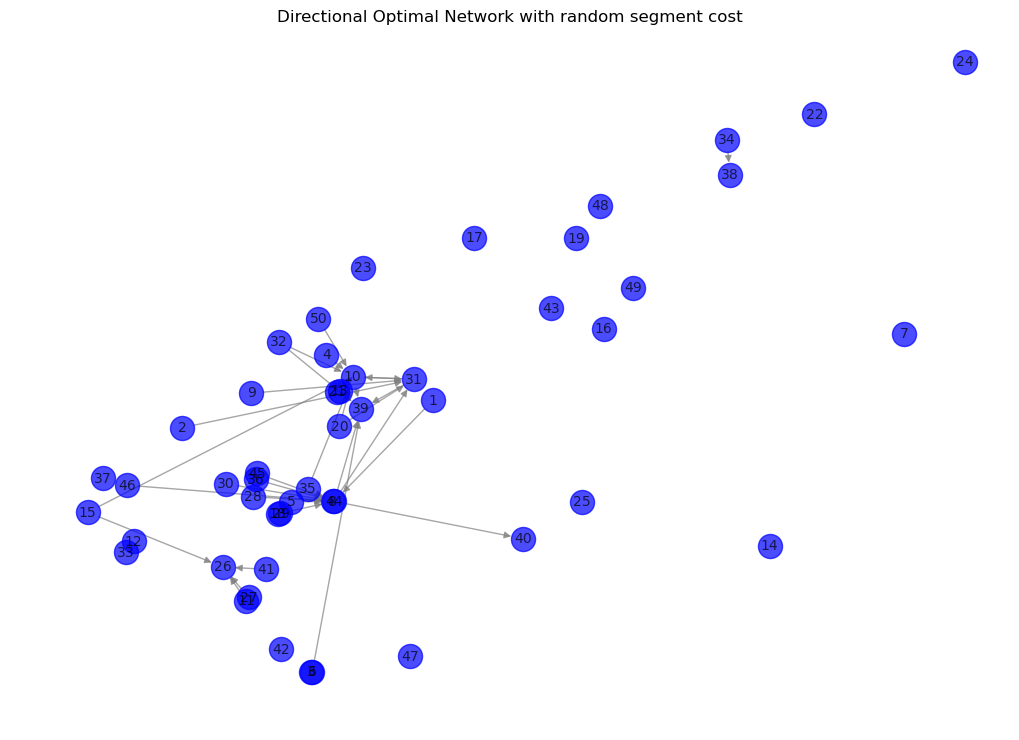

In [26]:
random_segment_cost = [random.randint(10,100) for i in range(len(segment_demand['segment_id']))]
segment_cost = {k:c for k,c in zip(segment_demand['segment_id'], random_segment_cost)}

optimize_bike_lane(road_segments, adjacent_segments, segment_demand_dict, intersection_stn_demand_dict,stations,segment_demand,B, # Fixed environment variables
                    segment_cost, # pseudo - constant variable (we change to understand results better, but would be fixed in real world)
                    lambda_param, env,
                    f'Directional Optimal Network with random segment cost'
                    )